#### `Nonlinear` least-squares (NLLS)

Find $x\in \mathbf{R}^n$ that minimizes

$$\|f(x)\|^2=\sum_{i=1}^mf_i(x)^2$$

where $f: \mathbf{R}^n \rightarrow \mathbf{R}^m$ and $m>n$

* $f(x)$ is a vector function
* the problem becomes linear least-squares when $f(x)=Ax-y$
* $f(x)$ in general case is hard to solve exactly
* `heuristics` to compute locally optimal solutions

#### `Gauss-Newton`

* `Guess` for $x^{k}$

* `Linearize` $f(x)$ near $x^{k}$
$$f(x)\approx f(x^{k})+Df(x^{k})(x-x^{k})$$
where $Df$ is the Jacobian: $Df_{ij}=\frac{\partial f_i}{\partial x_j}$, it is a `tall matrix`. Then write in $\color{orange}{Df(x^{k})}x-\color{red}{y^{k}}$ form
$$\color{orange}{Df(x^{k})}x-\color{red}{\left(Df(x^{k})x^{k}-f(x^{k})\right)}$$

* New guess is `linear least-squares solution`, using linearized $f(x)$
$$\begin{align*}
x^{k+1}&=\left(\color{orange}{Df(x^{k})}^T \color{orange}{Df(x^{k})}\right)^{-1}\color{orange}{Df(x^{k})}^T \color{red}{y^{k}} \\
&=\left(\color{orange}{Df(x^{k})}^T \color{orange}{Df(x^{k})}\right)^{-1}\color{orange}{Df(x^{k})}^T\left(\color{orange}{Df(x^{k})}x^{k}-f(x^{k})\right) \\
&=\boxed{x^{k}-\left(\color{orange}{Df(x^{k})}^T \color{orange}{Df(x^{k})}\right)^{-1}\color{orange}{Df(x^{k})}^Tf(x^{k})}
\end{align*}$$

* Repeat

#### Example: `position estimate from ranges`

Estimate position $x=\begin{bmatrix}x_1 \\x_2\end{bmatrix}\in \mathbf{R}^2$ from approximate distances to beacons at locations $b_1, \cdots, b_m \in \mathbf{R}^2$

* measurement at each beacon is $\rho_i=\|x-b_i\|+v_i$
* NLLS finds $x$ that minimizes

$$\|f(x)\|^2=\sum_{i=1}^m(\rho_i-\|x-b_i\|)^2$$

##### Generate `data`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')
np.set_printoptions(formatter={'float': '{: 0.2e}'.format})

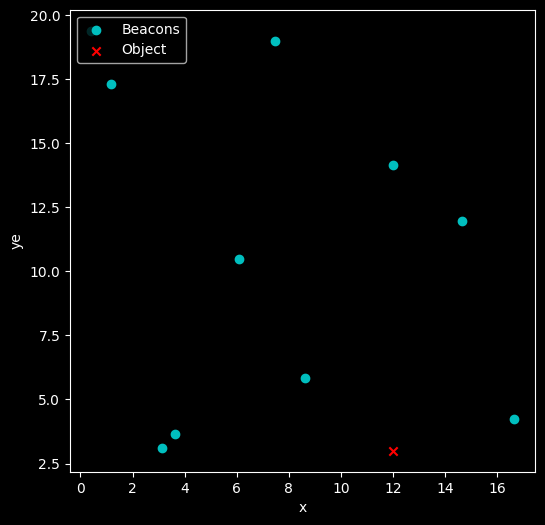

Beacons:
 [[ 7.49e+00  1.90e+01]
 [ 1.46e+01  1.20e+01]
 [ 3.12e+00  3.12e+00]
 [ 1.16e+00  1.73e+01]
 [ 1.20e+01  1.42e+01]
 [ 4.12e-01  1.94e+01]
 [ 1.66e+01  4.25e+00]
 [ 3.64e+00  3.67e+00]
 [ 6.08e+00  1.05e+01]
 [ 8.64e+00  5.82e+00]]

True Position:
 [12  3]

Measured distances (rho):
 [ 1.61e+01  9.51e+00  8.43e+00  1.73e+01  1.19e+01  2.00e+01  4.85e+00
  7.68e+00  9.28e+00  4.45e+00]

True distances:
 [ 1.66e+01  9.35e+00  8.88e+00  1.80e+01  1.12e+01  2.01e+01  4.81e+00
  8.39e+00  9.55e+00  4.39e+00]


In [2]:
np.random.seed(42)

# Beacons
m_beacons = 10
beacon_pos = np.random.rand(m_beacons, 2) * 20

# Object
obj_pos = np.array([12, 3]) # (2,)

# Measured distances with some noise
noise = np.random.normal(0, 0.5, m_beacons)  # (10,)
diff_vec = beacon_pos - obj_pos
rho = np.sqrt(np.sum(diff_vec ** 2, axis=1)) + noise

plt.figure(figsize=(6, 6))
plt.scatter(beacon_pos[:, 0], beacon_pos[:, 1], c='c', label='Beacons')
plt.scatter(obj_pos[0], obj_pos[1], c='r', marker='x', label='Object')
plt.legend(loc='upper left')
plt.xlabel('x')
plt.ylabel('ye')
# plt.grid(True)
plt.show()

print('Beacons:\n', beacon_pos)
print('\nTrue Position:\n', obj_pos)
print('\nMeasured distances (rho):\n', rho)
print('\nTrue distances:\n', np.sqrt(np.sum(diff_vec ** 2, axis=1)))

##### Compute `Jacobian`

The residual for the `ith` beacon is expressed as

$$\begin{align*}
f_i(x)&=\rho_i-\|x-b_i\| \\
&=\rho_i-\sqrt{(x_1-b_{i1})^2+(x_2-b_{i2})^2} \\
&=\rho_i-\sqrt{d_i}
\end{align*}$$

Now, we can compute the Jacobian

$$\begin{align*}Df_{ij}&=\frac{\partial f_i}{\partial x_j} \\
&=\frac{\partial f_i}{\partial d_i} \frac{\partial d_i}{\partial x_j}\\
&=-\frac{1}{2}\frac{1}{\sqrt{d_i}}\cdot 2(x_j-b_{ij})\\
&=-\frac{x_j-b_{ij}}{\sqrt{d_i}}
\end{align*}$$

In [3]:
# Compute residual function
def residual(x, beacons, rho):
    diffs = beacons - x # (10, 2)
    # print(diffs.shape)
    return rho - np.sqrt(np.sum(diffs ** 2, axis=1)) # (10,)

# Compute Jacobian of residual
def jacobian(x, beacons):
    diffs = x - beacons# (10, 2)
    # print(diffs.shape)
    dists = np.sqrt(np.sum(diffs ** 2, axis=1)).reshape(-1, 1) # (10, 1)
    # print(dists.shape)
    return -diffs / dists # (10, 2)

# Test to see whether shapes are correct
x_test = np.array([3., 2.])

residual_test = residual(x_test, beacon_pos, rho)
jacobian_test = jacobian(x_test, beacon_pos)

print('Initial Residual shape:', residual_test.shape)
print('\nInitial Residual:\n', residual_test)
print('\nInitial Jacobian shape:', jacobian_test.shape)
print('\nInitial Jacobian:\n', jacobian_test)

Initial Residual shape: (10,)

Initial Residual:
 [-1.47e+00 -5.82e+00  7.30e+00  1.82e+00 -3.25e+00  2.38e+00 -8.99e+00
  5.89e+00  2.38e-01 -2.37e+00]

Initial Jacobian shape: (10, 2)

Initial Jacobian:
 [[ 2.55e-01  9.67e-01]
 [ 7.59e-01  6.51e-01]
 [ 1.07e-01  9.94e-01]
 [-1.19e-01  9.93e-01]
 [ 5.96e-01  8.03e-01]
 [-1.47e-01  9.89e-01]
 [ 9.87e-01  1.62e-01]
 [ 3.57e-01  9.34e-01]
 [ 3.41e-01  9.40e-01]
 [ 8.28e-01  5.61e-01]]


##### `Iterations`

In [4]:
max_iterations = 10
tolerance = 1e-6

x_est = np.mean(beacon_pos, axis=0)
print('Initial estimate:', x_est)
estimates = [x_est.copy()]

for i in range(max_iterations):
    f = residual(x_est, beacon_pos, rho)
    Df = jacobian(x_est, beacon_pos)

    eigenvalues,_ = np.linalg.eigh(Df.T @ Df)
    print(f"Iter: {i}, Eigenvalues of Df.T @ Df: {eigenvalues}")

    # Gauss-Newton update
    delta_x = np.linalg.inv(Df.T @ Df) @ Df.T @ f
    x_est -= delta_x

    # Append new estimate
    estimates.append(x_est.copy())

    if np.linalg.norm(delta_x) < tolerance:
        print(f'Converged after {i+1} iterations')
        break

# Final estimated position
estimated_position = x_est

Initial estimate: [ 7.39e+00  1.09e+01]
Iter: 0, Eigenvalues of Df.T @ Df: [ 4.60e+00  5.40e+00]
Iter: 1, Eigenvalues of Df.T @ Df: [ 3.99e+00  6.01e+00]
Iter: 2, Eigenvalues of Df.T @ Df: [ 3.24e+00  6.76e+00]
Iter: 3, Eigenvalues of Df.T @ Df: [ 3.28e+00  6.72e+00]
Iter: 4, Eigenvalues of Df.T @ Df: [ 3.28e+00  6.72e+00]
Iter: 5, Eigenvalues of Df.T @ Df: [ 3.28e+00  6.72e+00]
Iter: 6, Eigenvalues of Df.T @ Df: [ 3.28e+00  6.72e+00]
Converged after 7 iterations


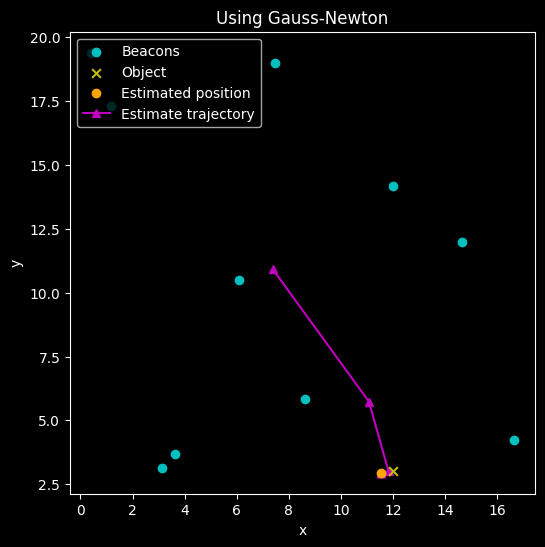

Estimated position: [ 1.16e+01  2.95e+00]
Estimation error: 0.45158463112995334


In [5]:
estimates_array = np.array(estimates)

plt.figure(figsize=(6, 6))
plt.scatter(beacon_pos[:, 0], beacon_pos[:, 1], c='c', label='Beacons')
plt.scatter(obj_pos[0], obj_pos[1],s=40, c='y', marker='x', label='Object', zorder=5)
plt.scatter(estimated_position[0], estimated_position[1], c='orange', marker='o', label='Estimated position', zorder=5)

# Plot trajectory
plt.plot(estimates_array[:, 0], estimates_array[:, 1], '-^', label='Estimate trajectory', color='m')

plt.legend(loc='upper left')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Using Gauss-Newton')

plt.show()

# Output final estimated position
print(f'Estimated position: {estimated_position}')
print(f'Estimation error: {np.linalg.norm(estimated_position - obj_pos)}')